### Prepare the Environment

First, you need to import the libraries you'll need. You can also import them as you find them necessary.

In [1]:
!pip install medigan
!pip install lmdb opencv-contrib-python easing-functions ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 34.9 MB/s eta 0:00:00
  Created wheel for medigan: filename=medigan-1.0.0-py3-none-any.whl size=58321 sha256=ec39ee9b5daff99d5f77ad85b07695e2d7ca47190fb7fa071b94204b36833a4a
  Stored in directory: /root/.cache/pip/wheels/40/db/d6/78c736ec5a682197ecc17266e95d2f8016be60fcb9ee57bb87
Successfully built medigan
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 7.7 MB/s eta 0:00:00


In [2]:
# Import the libraries that you need
from tqdm import tqdm
from pathlib import Path
import torch
import torch.optim as optim
import torchvision
import medigan 
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image

Check the availability of GPUs on this machine and determine the correct device name. Store the device name in the variable device.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


#### Getting Images

In [4]:
# Create the connection to the Medigan generators
generators = medigan.Generators()
# Find the models that match what we want
# Define search values
values = ["Polyp","endoscopy roi","FastGAN"]
# Find the models that match the search criteria
models = generators.find_matching_models_by_values(
    values=values, 
    is_case_sensitive=False
)
# Get the first matching model's ID
model_id = models[0].model_id
print(model_id)

00010_FASTGAN_POLYP_PATCHES_W_MASKS


Get the configuration for the model you found using the model_id. Save the model configuration to the model_config variable.

In [5]:
model_config = generators.get_config_by_id(model_id)
print(f"Model keys: {model_config.keys()}")

Model keys: dict_keys(['execution', 'selection', 'description'])


Select the generates, tags, height, and width keys from the selection key in the model configuration. Save the result to model_info, a dictionary that maps the selected keys to their values.

In [6]:
model_info = {
    key: model_config["selection"][key]
    for key in ["generates", "tags", "height", "width"]
    if key in model_config["selection"]
}
model_info

{'generates': ['masks',
  'segmentation masks',
  'polyp masks',
  'endoscopy masks',
  'endoscopy roi',
  'endoscopy ROI',
  'endoscopy images',
  'endoscopy region of interest',
  'polyp',
  'polyps',
  'polyp roi',
  'polyp ROI',
  'polyp images',
  'polyp region of interest'],
 'tags': ['Endoscopy',
  'Colonoscopy',
  'Polyps',
  'Polyp',
  'Polyp Segmentation',
  'Segmentation',
  '256x256',
  '256 x 256'],
 'height': 256,
 'width': 256}

Our next step is to generate the data. We'll need to define places where we'll store this data.



In [7]:
output_dir = Path("output_data")
sample_dir = output_dir/"sample"
# Create the directory with mkdir
sample_dir.mkdir(parents=True, exist_ok=True)
print(sample_dir)

output_data/sample


Generate 4 images using our selected GAN. Save them to sample_dir.

In [8]:
generators.generate(
    model_id=model_id,
    num_samples=10,
    output_path=sample_dir,
)

  0%|          | 0/1 [00:00<?, ?it/s]/kaggle/working/models/00010_FASTGAN_POLYP_PATCHES_W_MASKS/__init__.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

Now let's display the images.

In [9]:
def view_images(directory, num_images=4, glob_rule="*"):
    """Displays a sample of images in the given directory
    They'll display in rows of 4 images
    - directory: which directory to look for images
    - num_images: how many images to display (default 4, for one row)
    - glob_rule: argument to glob to filter images (default "*" selects all)"""

    image_list = [f for f in directory.glob(glob_rule) if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]
    num_samples = min(num_images, len(image_list))
    images = [read_image(str(f)) for f in sorted(image_list)[:num_images]]
    grid = make_grid(images, nrow=4, pad_value=255.0)
    return torchvision.transforms.ToPILImage()(grid)

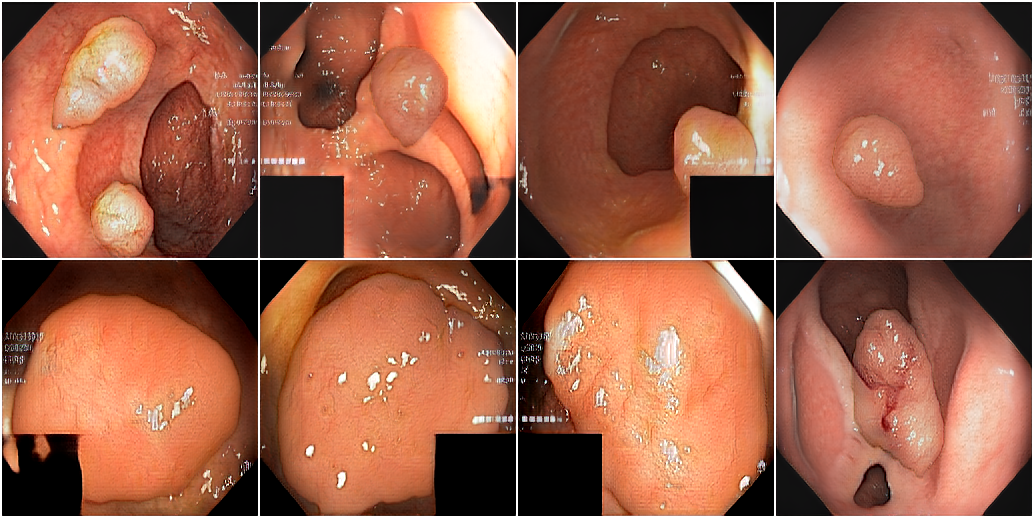

In [10]:
view_images(sample_dir, 8, "*img*")

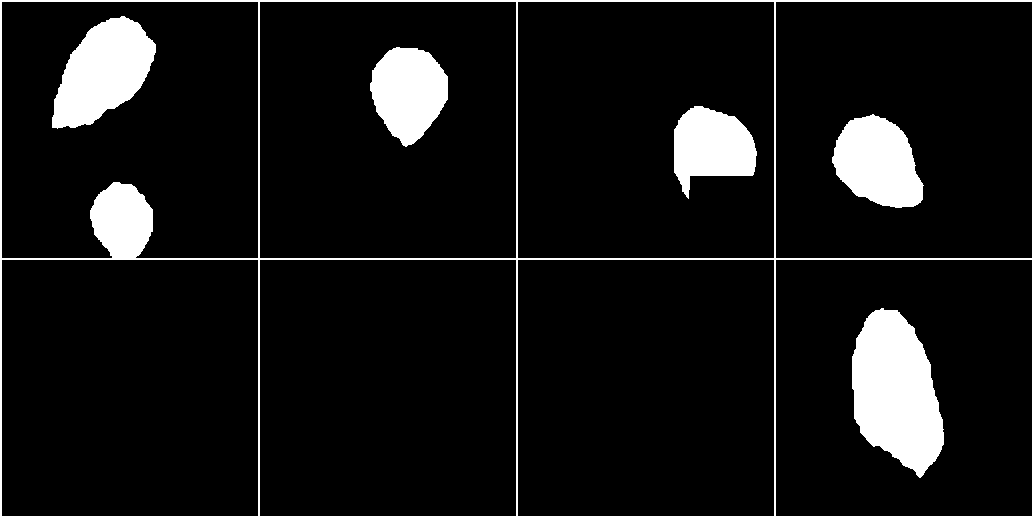

In [11]:
view_images(sample_dir, 8, "*mask*")

If we're going to use these generated images to train our model, we'll need a data loader. Medigan can provide one for us directly. We'll make both a training set and a validation set.

In [12]:
train_dataloader = generators.get_as_torch_dataloader(
    model_id=model_id, num_samples=200, batch_size=4, shuffle=True, prefetch_factor=None
)

sample_batch = next(iter(train_dataloader))
print(f"Training data loader with keys: {sample_batch.keys()}")

Training data loader with keys: dict_keys(['sample', 'mask'])


In [13]:
val_dataloader = generators.get_as_torch_dataloader(
    model_id=model_id, num_samples=50, batch_size=4, shuffle=False, prefetch_factor=None
)

val_batch = next(iter(train_dataloader))
shape = val_batch["sample"].shape
dtype = val_batch["sample"].dtype
print(f"Validation image with data shape {shape} and type {dtype}")

Validation image with data shape torch.Size([4, 256, 256, 3]) and type torch.float32


We'll need to fix this, we need the images to be [3, 256, 256] and the mask to be [1, 256, 256], and both to have type float32. This function converts the type and adds the channels.

In [14]:
def convert_to_torch_image(tensor, color=False):
    tensor_float = tensor.type(torch.float32)
    if color:
        return tensor_float.permute(0, 3, 1, 2)
    else:
        return tensor_float[:, :, :, :1].permute(0, 3, 1, 2)

Run this function on the mask component of val_batch and get the new shape and type.

In [15]:
mask_converted = convert_to_torch_image(val_batch["mask"], color=False)

shape = mask_converted.shape
dtype = mask_converted.dtype

print(f"Validation mask with data shape {shape} and type {dtype}")

Validation mask with data shape torch.Size([4, 1, 256, 256]) and type torch.float32


Run this function on the sample component of val_batch and get the new shape and type. You'll need to specify color=True to get RGB images.

In [16]:
sample_converted = convert_to_torch_image(val_batch["sample"], color=True)

shape = sample_converted.shape
dtype = sample_converted.dtype

print(f"Validation mask with data shape {shape} and type {dtype}")

Validation mask with data shape torch.Size([4, 3, 256, 256]) and type torch.float32


### Creating a Model

Now that we have our data, we'll want to train a model. This is a segmentation problem, and we found a good pre-trained model for that in one of the lessons. Let's use that one.

Load the pre-trained deeplabv3_resnet50 model. Use the COCO_WITH_VOC_LABELS_V1 weights.

In [17]:
pretrained_weights = (
    torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=pretrained_weights)

print("Model components:")
for name, part in model.named_children():
    print("\t" + name)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 211MB/s]


Model components:
	backbone
	classifier
	aux_classifier


Run the model on the sample part of our sample_batch, and get the shape of the out part of the result. You'll need to convert the data to the correct format.

In [18]:
sample_converted = convert_to_torch_image(sample_batch["sample"], color=True)
model_result = model(sample_converted)
model_out = model_result["out"]
out_shape = model_out.shape

out_shape

torch.Size([4, 21, 256, 256])

This doesn't match our masks. It's the right height and width, but the wrong number of channels. We'll replace that last layer. It's a convolution, but not the one we need.

In [19]:
model.classifier[-1]

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

Replace the last layer in the classifier with a convolution that gives the correct output shape to match our mask.

In [20]:
new_final_layer = torch.nn.Conv2d(in_channels=256,out_channels=1,kernel_size=(1,1))
model.classifier[-1] = new_final_layer

new_out = model(sample_converted)["out"]
print(f"New model output shape: {new_out.shape}")
print(f"Mask shape: {mask_converted.shape}")

New model output shape: torch.Size([4, 1, 256, 256])
Mask shape: torch.Size([4, 1, 256, 256])


We're also going to need a loss function and an optimizer for when we train. We'll use the same BCEWithLogitsLoss we used in the lesson, and an Adam optimizer.

In [21]:
loss_fun = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(lr=.0001,params=model.parameters())

opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

### Training

We'll need to train the model we just created. It'll be quite similar to training we've done in the past, but slightly adjusted due to the need to adjust the image and mask shapes, and getting the out part of the output.

We'll build up a few functions to put this together. First, we'll deal with calculating the loss. The function below outlines this, but the details are missing.

In [22]:
def compute_loss(batch, model, loss_fun):
    # Extract the sample and mask from the batch
    sample = batch["sample"]
    mask = batch["mask"]

    # Convert the sample and mask to the correct shape and type
    sample_correct = convert_to_torch_image(sample, color=True)
    mask_correct = convert_to_torch_image(mask, color=False)

    # move the sample and mask to the GPU
    sample_gpu = sample_correct.to(device)
    mask_gpu = mask_correct.to(device)

    # Run the model on the sample and select the classifier (out key)
    output = model(sample_gpu)["out"]

    # Compute the loss
    loss = loss_fun(output,mask_gpu)

    return loss

In [23]:
model.to(device)
compute_loss(sample_batch, model, loss_fun)

tensor(0.7054, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [24]:
# Step 5: Callbacks
class Callback:
    def __init__(self, patience=3, min_delta=0.001, lr_scheduler=None, factor=0.1, lr_patience=2):
        """
        Args:
            patience (int): Number of epochs to wait before early stopping if no improvement.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
            lr_scheduler (torch.optim.lr_scheduler.ReduceLROnPlateau): Learning rate scheduler.
            factor (float): Factor by which to reduce learning rate.
            lr_patience (int): Number of epochs to wait before reducing learning rate.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        # Learning Rate Scheduler
        self.lr_scheduler = lr_scheduler
        self.lr_patience = lr_patience
        self.lr_counter = 0  # Tracks epochs without improvement for LR scheduling
        self.factor = factor

    def on_epoch_end(self, val_loss, model, optimizer):
        """
        Called at the end of each epoch.
        
        Args:
            val_loss (float): Validation loss.
            model (torch.nn.Module): The model being trained.
            optimizer (torch.optim.Optimizer): The optimizer being used.
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.lr_counter = 0  # Reset LR counter
            torch.save(model,'best_model.pth') # Save best model
            print(f"Best model saved with validation loss: {val_loss:.4f}")
        else:
            self.counter += 1
            self.lr_counter += 1
            # Reduce learning rate if no improvement for `lr_patience` epochs
            if self.lr_scheduler and self.lr_counter >= self.lr_patience:
                self.lr_scheduler.step(val_loss)
                self.lr_counter = 0  # Reset LR counter
            # Trigger early stopping if no improvement for `patience` epochs
            if self.counter >= self.patience:
                self.early_stop = True

In [25]:
def train_epoch(model, train_dataloader, val_dataloader, loss_fun, opt):
    model.train()

    # Training part
    train_loss = 0.0
    train_count = 0
    for batch in tqdm(train_dataloader,desc="Training", leave=False):
        # zero the gradients on the optimizer
        opt.zero_grad()

        # compute the loss for the batch
        loss = compute_loss(batch, model, loss_fun)

        # Compute the backward part of the loss and step the optimizer
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_count += 1

    # Validation part
    val_loss = 0.0
    val_count = 0
    for batch in tqdm(val_dataloader,desc="Validation", leave=False):
        # compute the loss for each batch
        loss = compute_loss(batch, model, loss_fun)

        val_loss += loss.item()
        val_count += 1

    return train_loss / train_count, val_loss / val_count

In [26]:
# Initialize the callback
callback = Callback(patience=3, min_delta=0.001, lr_scheduler=None)

epochs = 50
for epoch in range(epochs):
    train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, loss_fun, opt)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Call the callback at the end of each epoch
    callback.on_epoch_end(val_loss, model, opt)

    # Check if early stopping condition is met
    if callback.early_stop:
        print("Early stopping triggered.")
        break

Epoch 1/50: Train Loss = 0.4644, Val Loss = 0.3112
Best model saved with validation loss: 0.3112


Epoch 2/50: Train Loss = 0.2650, Val Loss = 0.2277
Best model saved with validation loss: 0.2277


Epoch 3/50: Train Loss = 0.1927, Val Loss = 0.1688
Best model saved with validation loss: 0.1688


Epoch 4/50: Train Loss = 0.1532, Val Loss = 0.1985


Epoch 5/50: Train Loss = 0.1451, Val Loss = 0.1402
Best model saved with validation loss: 0.1402


Epoch 6/50: Train Loss = 0.1091, Val Loss = 0.1115
Best model saved with validation loss: 0.1115


Epoch 7/50: Train Loss = 0.0965, Val Loss = 0.0971
Best model saved with validation loss: 0.0971


Epoch 8/50: Train Loss = 0.0763, Val Loss = 0.0884
Best model saved with validation loss: 0.0884


Epoch 9/50: Train Loss = 0.0622, Val Loss = 0.0813
Best model saved with validation loss: 0.0813


Epoch 10/50: Train Loss = 0.0580, Val Loss = 0.0746
Best model saved with validation loss: 0.0746


Epoch 11/50: Train Loss = 0.0560, Val Loss = 0.1015


Epoch 12/50: Train Loss = 0.0596, Val Loss = 0.1881


Epoch 13/50: Train Loss = 0.0790, Val Loss = 0.0926
Early stopping triggered.


### Testing the Model

Let's see how well we did. First, we'll need some new data to test on.

Use Medigan to create a data loader of test data. This time only create 
 images and don't shuffle. All other settings should be the same as our earlier loaders.

In [27]:
test_dataloader = generators.get_as_torch_dataloader(
    model_id=model_id, num_samples=20, batch_size=4, shuffle=False, prefetch_factor=None
)

test_batch = next(iter(test_dataloader))

print(f"Data loader images in batches of {test_batch['sample'].size(0)}")

Data loader images in batches of 4


Run the model on the test_batch, and save the out to test_result. You'll need to first convert the sample

In [28]:
model = torch.load('best_model.pth',weights_only=False)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [29]:
test_result = model(convert_to_torch_image(test_batch["sample"],color=True).to(device))["out"]
test_result.shape

torch.Size([4, 1, 256, 256])

 Apply the sigmoid function to the test_result. Save the output to test_mask_model.

In [30]:
test_mask_model = torch.sigmoid(test_result)

In [31]:
def plot_images_from_tensor(tensor):
    grid = make_grid(tensor, nrow=4, pad_value=1.0)
    return torchvision.transforms.ToPILImage()(grid)

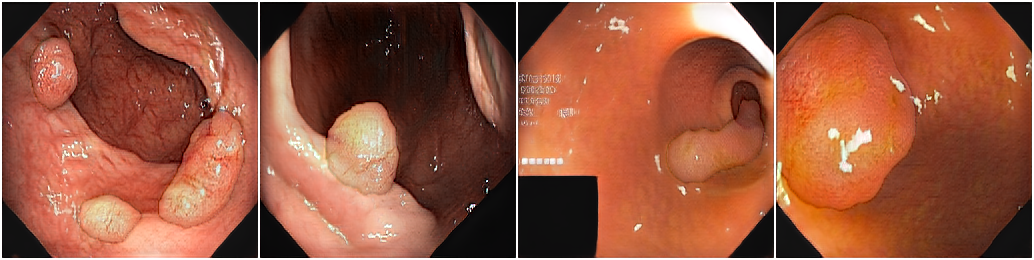

In [32]:
# Plot the sample part of the test_batch
sample_test_batch_plot = plot_images_from_tensor(convert_to_torch_image(test_batch["sample"],color=True))
sample_test_batch_plot

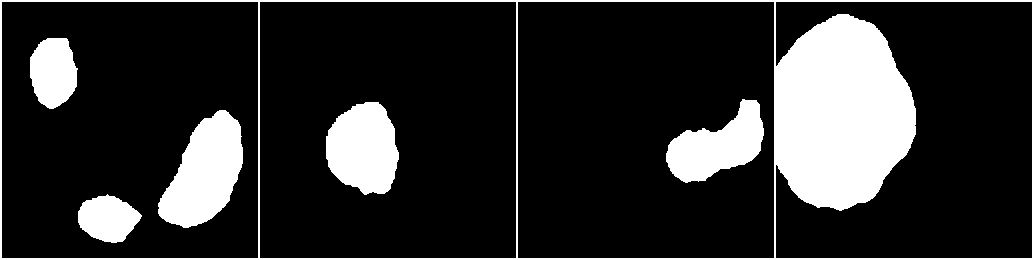

In [33]:
# Plot the mask part of the test_batch
mask_test_batch_plot = plot_images_from_tensor(convert_to_torch_image(test_batch["mask"],color=False))
mask_test_batch_plot

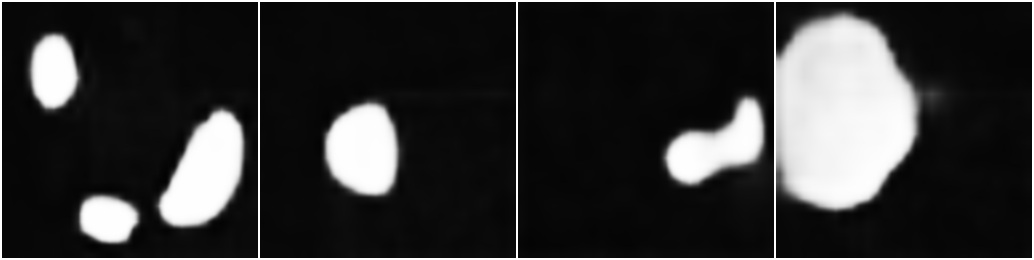

In [34]:
# Plot the result of the model running
model_result_plot = plot_images_from_tensor(test_mask_model)
model_result_plot